# Stock Prediction Classfication

In [1]:
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = "tMcAQrxVdSPB8yifJGX6"
import talib as ta
import cPickle as pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

from sklearn import neighbors
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Get stock info from Quandl

In [2]:
def getStockFromQuandlRaw(symbol, start, end):
    # Downloads Stock from Quandl.
    # Computes daily Returns based on Adj Close.
    # Returns pandas dataframe.
    dataframe =  quandl.get('WIKI/%s'%symbol, trim_start = start, trim_end = end, authtoken = quandl.ApiConfig.api_key)
    # Token = personal authrization.
    return dataframe

In [3]:
symbol = "AAPL"
start = "20120101"
end = "20161231"
start_test = "20160601"
index = "Adj. Low"

In [4]:
getStockFromQuandlRaw(symbol, start, end).head(n=5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-01-03,409.4000,412.50,409.00,411.23,10793600.0,0.0,1.0,52.613606,53.011999,52.562200,52.848787,75555200.0
2012-01-04,410.0000,414.68,409.28,413.44,9286500.0,0.0,1.0,52.690714,53.292160,52.598184,53.132802,65005500.0
2012-01-05,414.9500,418.55,412.67,418.03,9688200.0,0.0,1.0,53.326858,53.789509,53.033847,53.722681,67817400.0
2012-01-06,419.7700,422.75,419.22,422.40,11367600.0,0.0,1.0,53.946296,54.329267,53.875613,54.284287,79573200.0
2012-01-09,425.5001,427.75,421.35,421.73,14072300.0,0.0,1.0,54.682693,54.971837,54.149348,54.198183,98506100.0


In [5]:
getStockFromQuandlRaw(symbol, start, end).tail(n=5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-12-23,115.59,116.5200,115.59,116.52,14249484.0,0.0,1.0,114.162295,115.080808,114.162295,115.080808,14249484.0
2016-12-27,116.52,117.8000,116.49,117.26,18296855.0,0.0,1.0,115.080808,116.344998,115.051178,115.811668,18296855.0
2016-12-28,117.52,118.0166,116.20,116.76,20905892.0,0.0,1.0,116.068456,116.558923,114.764760,115.317843,20905892.0
2016-12-29,116.45,117.1095,116.40,116.73,15039519.0,0.0,1.0,115.011672,115.663027,114.962290,115.288214,15039519.0
2016-12-30,116.65,117.2000,115.43,115.82,30586265.0,0.0,1.0,115.209202,115.752409,114.004271,114.389454,30586265.0


In [6]:
def count_missing(dataframe):
    """
    count number of NaN in dataframe
    """
    return (dataframe.shape[0] * dataframe.shape[1]) - sum(dataframe.count())

### Check Data Size 

In [8]:
RawData = getStockFromQuandlRaw(symbol, start, end)
print ('Size of data frame: ', RawData.shape)
print ('Number of Missing Data: ', count_missing(RawData))

('Size of data frame: ', (1258, 12))
('Number of Missing Data: ', 0)


### Raw Data Statistical Description 

In [9]:
RawData.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,1258.000000,1258.000000,1258.00000,1258.000000,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,313.501630,316.317304,310.32547,313.328844,3.168134e+07,0.022766,1.004769,88.168503,88.955748,87.317829,88.143001,7.730747e+07
std,215.873479,217.741565,213.58769,215.685229,2.215453e+07,0.237945,0.169165,20.961954,21.107021,20.808053,20.965031,5.062673e+07
min,90.000000,90.700000,89.47000,90.280000,5.704900e+06,0.000000,1.000000,50.594952,52.111614,50.220677,50.928800,1.147592e+07
25%,109.742500,110.782500,108.66250,109.607500,1.387215e+07,0.000000,1.000000,70.215720,70.997963,69.654731,70.194775,4.192546e+07
50%,130.000000,130.795000,128.69250,129.815000,2.697295e+07,0.000000,1.000000,89.162389,89.791406,88.223569,89.182554,6.316127e+07
75%,527.895000,531.950000,522.36000,527.412500,4.380281e+07,0.000000,1.000000,106.862058,107.777438,105.894247,106.912899,9.738960e+07
max,702.410000,705.070000,699.57000,702.100000,1.895606e+08,3.290000,7.000000,128.233349,128.314416,125.839962,126.931724,3.765300e+08


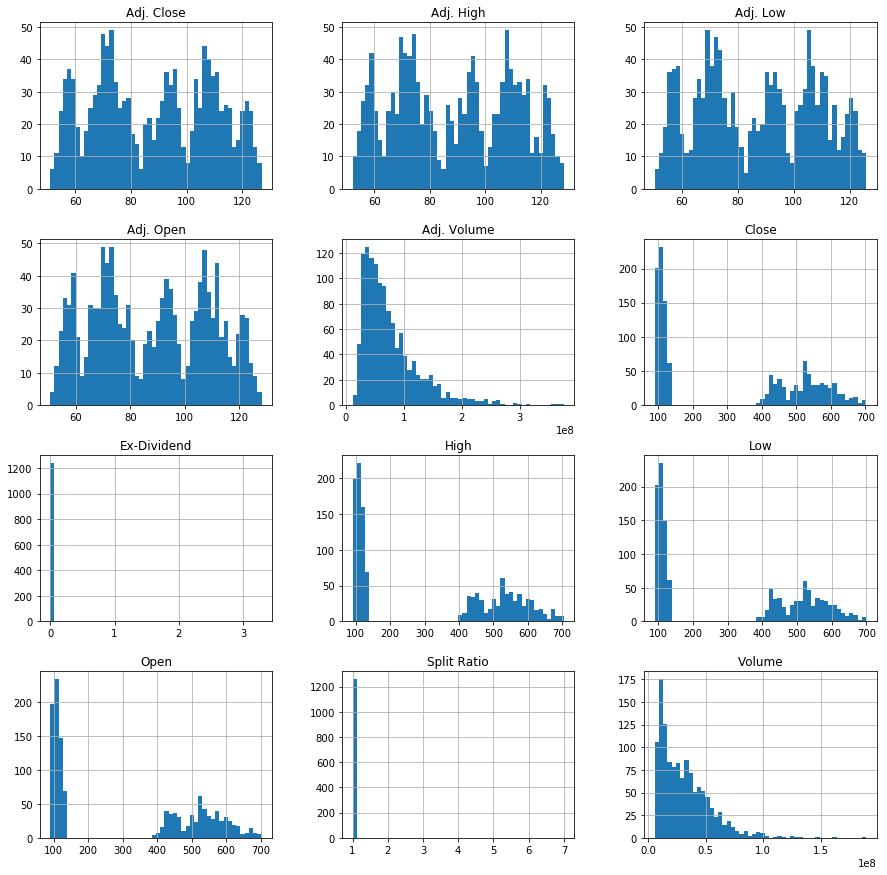

In [11]:
import matplotlib.pyplot as plt
RawData.hist(figsize=(15,15),bins=50) 
plt.show()

# Pre-Processing features

In [7]:
def getStockFromQuandl(symbol, start, end, index):
    
    # Downloads Stock from Quandl.
    # Computes daily Returns based on Adj Close.
    # Returns pandas dataframe.
    
    df =  quandl.get('WIKI/%s'%symbol, trim_start = start, trim_end = end,   
                      authtoken="tMcAQrxVdSPB8yifJGX6")
    drop = (df.columns.get_loc(index)) + 1
    finance = df.iloc[:, drop:]
    # Reserve data after Adj. Low based on Quandl Wiki Data format"""
    finance.columns.values[-2] = 'Close'
    finance.columns.values[-1] = 'Volume'
    finance.loc[:, 'Return'] = np.log(finance['Close']/finance['Close'].shift())
    # Feature Engineering
    # Generate Log Transformation Return feature"""
     
    finance.loc[:, 'Return_T'] = finance['Return'].shift(-1)
    # Shift Return 1-day backward to predict T+1's return as Target Column"""
    return finance

### Check Data Size 

In [8]:
PreprocessedData = getStockFromQuandl(symbol, start, end, index)
print ('Size of data frame: ', PreprocessedData.shape)

/Users/IanHuang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/IanHuang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


('Size of data frame: ', (1258, 4))


## Extending Data Range for later Data Engineering

In [9]:
import pendulum
from dateutil import parser

start_date = pendulum.parse(start, strict=True)
end_date = pendulum.parse(end, strict=True)
    
pre_process_start_date = start_date.subtract(days = 350) # Tracing Back 250 Trading Days (-(250/5)*7) = 350 Calendar Days
pre_process_end_date = end_date.add(days = 5) # Adding 1 Trading Days for later cut-off (+ 5 days) = 5 Calendar Days
    
ExtendedData = getStockFromQuandl(symbol, pre_process_start_date, pre_process_end_date, index)
print ('Size of data frame: ', ExtendedData.shape)
print ('First data entry date: ', parser.parse(str(ExtendedData.index[0])).date().isoformat(), 'Last data entry date: ', parser.parse(str(ExtendedData.index[-1])).date().isoformat())
print ('Number of NaN of final data frame: ', count_missing(ExtendedData)) # Confirming no NaN
print (ExtendedData.head(n=5))
print (ExtendedData.tail(n=5))

('Size of data frame: ', (1503, 4))
('First data entry date: ', '2011-01-18', 'Last data entry date: ', '2017-01-05')
('Number of NaN of final data frame: ', 2)
                Close       Volume    Return  Return_T
Date                                                  
2011-01-18  43.778273  470249500.0       NaN -0.005328
2011-01-19  43.545663  283903200.0 -0.005328 -0.018347
2011-01-20  42.754017  191197300.0 -0.018347 -0.018078
2011-01-21  41.988074  188600300.0 -0.018078  0.032314
2011-01-24  43.367028  143670800.0  0.032314  0.011637
                 Close      Volume    Return  Return_T
Date                                                  
2016-12-29  115.288214  15039519.0 -0.000257 -0.007826
2016-12-30  114.389454  30586265.0 -0.007826  0.002845
2017-01-03  114.715378  28781865.0  0.002845 -0.001120
2017-01-04  114.586983  21118116.0 -0.001120  0.005072
2017-01-05  115.169696  22193587.0  0.005072       NaN


## Add new features

In [10]:
def addFeatures(dataframe, n1, n2):
    
    # Operates on return column of dataframe:
    # n1 = 50, n2 = 200(commonly used)
    # Given Return_* computes the return of day i respect to day i-n.      
    returns = dataframe.Return
    close = dataframe.Close.values
    volume = dataframe.Volume.values 
    
    # Add 30 Days Rolling Returns   
    RR = "RR-30" 
    dataframe[RR] = returns.rolling(30).mean()
    
    # Applying EMA-50 Days, EMA-200 Days, and MACD Signal Line-9 Days 
    EMA_n1 = "EMA" + '-' + str(n1)
    EMA_n2 = "EMA" + '-' + str(n2)
    dataframe[EMA_n1] = ta.EMA(close, timeperiod=n1)
    dataframe[EMA_n2] = ta.EMA(close, timeperiod=n2)
    
    # Add MACD(Moving Average Convergence/Divergence), operates on Close column of dataframe:
    # Given Closing price computes MACD of the period. 
    # Applying standard EMA-12 Days, EMA-26 Days, and MACD Signal Line-9 Days   
    MACD, _, _ = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)    
    dataframe['MACD'] = pd.Series(MACD, index=dataframe.index)
    
    # Add OBV(On Balance Volume), operates on Close and Volume columns of dataframe:
    # Given closing price and volume computes OBV of the period.    
    obv = ta.OBV(close, volume)    
    dataframe['OBV'] = pd.Series(obv, index=dataframe.index)
    
    # Add PPO(Percentage Price Oscillator), operates on Close columns of dataframe:
    # Given closing price computes PPO of the period. MA_Type: 0=SMA, 1= EMA
    ppo = ta.PPO(close, fastperiod=12, slowperiod=26, matype=1)
    dataframe['PPO'] = pd.Series(ppo, index=dataframe.index)
    
    ### Add RSI(Relative Strength Index), operates on Close columns of dataframe:
    ### given closing price computes PPO of the period.     
    rsi = ta.RSI(close, timeperiod=14)
    dataframe['RSI'] = pd.Series(rsi, index=dataframe.index)
    
    return dataframe

In [12]:
### Input: Exponential Moveing Average Window Length
n1 = 50
n2 = 200

### Add Features, Data Range Cutoff, and Verify no NaN Columns

In [13]:
dataset = addFeatures(ExtendedData, n1, n2)
print ('Size of data frame after feature engineering: ', dataset.shape)
print ('Number of NaN after feature engineering: ', count_missing(dataset))

finance = dataset.iloc[:, 2:]
finance = finance.dropna()
print ('Size of data frame after dropping Nan: ', finance.shape)
print ('Number of NaN after dropping: ', count_missing(finance)) # Confirming no NaN
print ('First data entry date: ', parser.parse(str(finance.index[0])).date().isoformat(), 'Last data entry date: ', parser.parse(str(finance.index[-1])).date().isoformat())    

# Make sure Start Date is later than first data entry data, and End Date is earlier than last data entry date.
final = finance.loc[start : end] # Data testing range
print ('Start date: ', start, 'End date: ', end)
print ('Size of final data frame: ', final.shape)
print ('Number of NaN of final data frame: ', count_missing(final)) # Confirming no NaN

('Size of data frame after feature engineering: ', (1503, 11))
('Number of NaN after feature engineering: ', 352)
('Size of data frame after dropping Nan: ', (1303, 9))
('Number of NaN after dropping: ', 0)
('First data entry date: ', '2011-10-31', 'Last data entry date: ', '2017-01-04')
('Start date: ', '20120101', 'End date: ', '20161231')
('Size of final data frame: ', (1258, 9))
('Number of NaN of final data frame: ', 0)


### Quick Glimpse

In [14]:
print (final.head(n=5))

              Return  Return_T     RR-30     EMA-50    EMA-200      MACD  \
Date                                                                       
2012-01-03  0.015266  0.005360  0.002861  50.347576  47.607900  0.701226   
2012-01-04  0.005360  0.011041  0.003258  50.456801  47.662875  0.786613   
2012-01-05  0.011041  0.010400  0.004158  50.584874  47.723171  0.891603   
2012-01-06  0.010400 -0.001587  0.003834  50.729949  47.788456  1.008500   
2012-01-09 -0.001587  0.003574  0.004634  50.865959  47.852234  1.081724   

                    OBV       PPO        RSI  
Date                                          
2012-01-03 -106000300.0  1.382815  66.164034  
2012-01-04  -40994800.0  1.545727  67.541068  
2012-01-05   26822600.0  1.744841  70.249199  
2012-01-06  106395800.0  1.964535  72.593646  
2012-01-09    7889700.0  2.098506  71.661242  


In [15]:
print (final.tail(n=5))

              Return  Return_T     RR-30      EMA-50     EMA-200      MACD  \
Date                                                                         
2016-12-23  0.001976  0.006331  0.002596  111.216212  106.598184  1.501988   
2016-12-27  0.006331 -0.004273  0.002610  111.396426  106.689861  1.546350   
2016-12-28 -0.004273 -0.000257  0.003314  111.550207  106.775711  1.524092   
2016-12-29 -0.000257 -0.007826  0.002867  111.696795  106.860413  1.486920   
2016-12-30 -0.007826  0.002845  0.001722  111.802390  106.935329  1.369157   

                    OBV       PPO        RSI  
Date                                          
2016-12-23 -199764178.0  1.336777  65.182567  
2016-12-27 -181467323.0  1.373135  67.751025  
2016-12-28 -202373215.0  1.350967  64.299536  
2016-12-29 -217412734.0  1.315881  64.088572  
2016-12-30 -247998999.0  1.210560  57.884634  


## Descriptive Statistics

In [16]:
final.describe()

,Return,Return_T,RR-30,EMA-50,EMA-200,MACD,OBV,PPO,RSI
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000
mean,0.000626,0.000616,0.000645,86.944158,83.446403,0.344805,-1.800826e+08,0.414250,54.141609
std,0.016465,0.016460,0.003124,20.700330,20.012293,1.619666,8.886566e+08,1.938722,13.448955
min,-0.131875,-0.131875,-0.007874,50.347576,47.607900,-4.131235,-2.316243e+09,-4.933670,21.458262
25%,-0.007353,-0.007353,-0.001350,70.854835,66.089910,-0.627193,-6.281610e+08,-0.674138,44.808126
50%,0.000473,0.000473,0.000772,84.507534,75.008612,0.358710,-2.177654e+08,0.408057,53.270271
75%,0.009742,0.009716,0.002706,104.822764,104.411536,1.450259,3.474067e+08,1.730767,64.261031
max,0.085022,0.085022,0.008941,122.378996,113.877840,4.764996,3.099381e+09,5.381817,88.056048


## Data Visualization

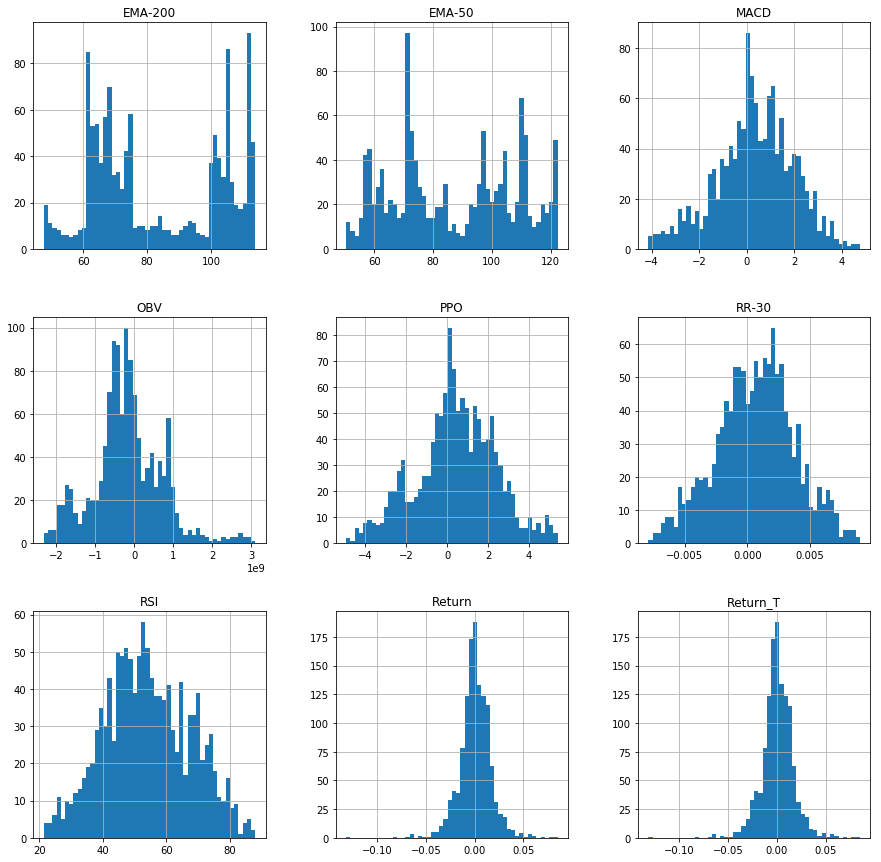

In [21]:
final.hist(figsize=(15,15),bins=50) 
plt.show()

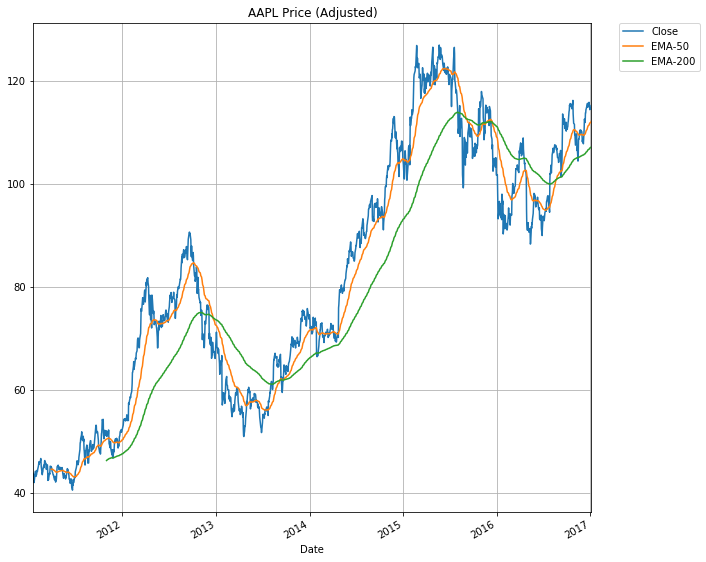

In [17]:
EMA_50 = dataset['EMA-50']
EMA_200 = dataset['EMA-200']
ax = dataset['Close'].plot(title='%s Price (Adjusted)'%symbol, color = 'C0', figsize = (10,10))

EMA_50.plot(label='EMA-50', ax=ax, color = 'C1' )
EMA_200.plot(label='EMA-200', ax=ax, color = 'C2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)

plt.show()

## Implementation

### Prepare Data For Classification

In [18]:
def prepareDataForClassification(dataset, start_test):
    """
    generates categorical output column, attach to dataframe 
    label the categories and split into train and test
    """
    le = preprocessing.LabelEncoder()
    
    dataset.loc[:,'UpDown'] = dataset.loc[:, 'Return_T']
    
    dataset.UpDown.loc[lambda s: s >= 0] = 'Up'    
    dataset.UpDown.loc[lambda s: s < 0] = 'Down'
    dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)
    
    dataset_drop = dataset.drop('Return_T', axis = 1)
    features = dataset_drop.columns[0:-1]
    X = dataset.loc[:, features]    
    y = dataset.UpDown    
    
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]              
        
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
        
    return X_train, y_train, X_test, y_test 

In [19]:
X_train, y_train, X_test, y_test  = prepareDataForClassification(final, start_test)

/Users/IanHuang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/IanHuang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/IanHuang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added b

In [20]:
print X_train.head()

              Return     RR-30     EMA-50    EMA-200      MACD          OBV  \
Date                                                                          
2012-01-03  0.015266  0.002861  50.347576  47.607900  0.701226 -106000300.0   
2012-01-04  0.005360  0.003258  50.456801  47.662875  0.786613  -40994800.0   
2012-01-05  0.011041  0.004158  50.584874  47.723171  0.891603   26822600.0   
2012-01-06  0.010400  0.003834  50.729949  47.788456  1.008500  106395800.0   
2012-01-09 -0.001587  0.004634  50.865959  47.852234  1.081724    7889700.0   

                 PPO        RSI  
Date                             
2012-01-03  1.382815  66.164034  
2012-01-04  1.545727  67.541068  
2012-01-05  1.744841  70.249199  
2012-01-06  1.964535  72.593646  
2012-01-09  2.098506  71.661242  


In [21]:
print X_train.tail()

              Return     RR-30     EMA-50     EMA-200      MACD          OBV  \
Date                                                                           
2016-05-24  0.015129 -0.003814  96.646582  102.479233 -1.622801 -554639693.0   
2016-05-25  0.017416 -0.003713  96.674457  102.428269 -1.147499 -515997585.0   
2016-05-26  0.007899 -0.003468  96.731515  102.385495 -0.700447 -459666426.0   
2016-05-27 -0.000598 -0.002812  96.784037  102.342562 -0.346887 -496007666.0   
2016-05-31 -0.004895 -0.002248  96.815719  102.295292 -0.104129 -538314878.0   

                 PPO        RSI  
Date                             
2016-05-24 -1.716726  53.503567  
2016-05-25 -1.211230  58.304305  
2016-05-26 -0.737393  60.330266  
2016-05-27 -0.364309  60.091451  
2016-05-31 -0.109157  58.069801  


In [26]:
print y_train.head()

Date
2012-01-03    1
2012-01-04    1
2012-01-05    1
2012-01-06    0
2012-01-09    1
Name: UpDown, dtype: int64


In [27]:
print y_train.tail()

Date
2016-05-24    1
2016-05-25    1
2016-05-26    0
2016-05-27    0
2016-05-31    0
Name: UpDown, dtype: int64


In [34]:
print y_test.tail()

Date
2016-12-23    1
2016-12-27    0
2016-12-28    0
2016-12-29    0
2016-12-30    1
Name: UpDown, dtype: int64


## Perform Classfication Algorithms

In [22]:
def performClassification(X_train, y_train, X_test, y_test, method, parameters, symbol, savemodel):
    """
    performs classification on daily returns using several algorithms (method).
    method --> string algorithm
    parameters --> list of parameters passed to the classifier (if any)
    symbol --> string with name of stock to be predicted
    savemodel --> boolean. If TRUE saves the model to pickle file
    """
    if method == 'LR':
        return performLRClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
        
    elif method == 'NB':
        return performNBClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
    
    elif method == 'RF':   
        return performRFClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
        
    elif method == 'KNN':
        return performKNNClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
    
    elif method == 'SVM':   
        return performSVMClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
    
    elif method == 'ADA':
        return performAdaBoostClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
    
    elif method == 'GTB': 
        return performGTBClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
 
    elif method == 'QDA': 
        return performQDAClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)
    
    elif method == 'LRRe': 
        return performLRReClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)


### Classfication Algorithms

In [23]:
### Logestic Regression Classification
def performLRClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    clf = linear_model.LogisticRegression()
    clf.fit(X_train, y_train)
    
    if savemodel == True:
        fname_out = 'LR_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    return accuracy

### Gaussian Naive Bayes Classification
def performNBClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    
    if savemodel == True:
        fname_out = 'NB_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    return accuracy

### Random Forest Binary Classification
def performRFClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    clf = RandomForestClassifier(n_estimators = 10)
    clf.fit(X_train, y_train)
    
    if savemodel == True:
        fname_out = 'RF_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    return accuracy

### KNN binary Classification
def performKNNClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    w = parameters[0]
    n = parameters[1]
    clf = neighbors.KNeighborsClassifier(weights = w, n_neighbors = n)
    
    clf.fit(X_train, y_train)
 
    if savemodel == True:
        fname_out = 'KNN_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)  
    return accuracy

### SVM binary Classification
def performSVMClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):    
    
    c = parameters[0] # Penalty parameter, default=1.0
    k =  parameters[1] # Kernel, default=’rbf’, one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
    clf = svm.SVC(C=c, kernel=k)
    clf.fit(X_train, y_train)
 
    if savemodel == True:
        fname_out = 'SVM_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)  
    
    return accuracy

### Ada Boosting binary Classification
def performAdaBoostClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):

    n = parameters[0]
    l =  parameters[1]
    clf = AdaBoostClassifier(n_estimators=n, learning_rate=l)
    clf.fit(X_train, y_train)
 
    if savemodel == True:
        fname_out = 'Ada_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)   
    return accuracy

### Gradient Tree Boosting binary Classification
def performGTBClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):

    clf = GradientBoostingClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
 
    if savemodel == True:
        fname_out = 'GTB_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    return accuracy

### Quadratic Discriminant Analysis binary Classification
def performQDAClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train) 
 
    if savemodel == True:
        fname_out = 'QDA_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    return accuracy

In [30]:
### Logestic Regression Classification -Refinement
def performLRReClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    c = parameters[0] # Penalty parameter, default=1.0
    s = parameters[1] # {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’ 
    clf = linear_model.LogisticRegression(C = c, solver = s)
    clf.fit(X_train, y_train)
    
    if savemodel == True:
        fname_out = 'LR_Re_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    return accuracy

In [ ]:
### KNN binary Classification- Grid Search
def performKNNGRClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel):
    
    tuned_parameters = [{'weights': ['uniform'],'n_neighbors': [10, 20, 30, 50]},
                    {'weights': ['distance'], 'n_neighbors': [10, 20, 30, 50]}]

    
    clf = GridSearchCV(neighbors.KNeighborsClassifier(),tuned_parameters)
    clf.fit(X_train, y_train)
 
    if savemodel == True:
        fname_out = 'KNN_{}.pickle'.format(symbol)
        with open(fname_out, 'wb') as f:
            pickle.dump(clf, f, -1)    
    
    accuracy = clf.score(X_test, y_test)
    
    print("Best parameters set found:")
    print()
    print(clf.best_params_)
    
    
    return accuracy

### Time Series Cross Validation

In [24]:
from sklearn.model_selection import TimeSeriesSplit
       
def performTimeSeriesCV(X_train, y_train, number_folds, method, parameters, symbol, savemodel):
    print ('Parameters --------------------------------> ', parameters)
    print ('Size train set: ', X_train.shape)
    tscv = TimeSeriesSplit(n_splits=number_folds - 1)
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print ('Size of each fold: ', k)
    
    accuracies = np.zeros(number_folds-1)
 
    # loop from the first 2 folds to the total number of folds    
    i = 2
    for train_index, test_index in tscv.split(X_train):
        # folds used to train the model        
        X_trainFolds = X_train[:len(train_index)]     
        y_trainFolds = y_train[:len(train_index)]

        # fold used to test the model
        X_testFolds = X_train[len(train_index):(len(train_index)+len(test_index))]
        y_testFolds = y_train[len(train_index):(len(train_index)+len(test_index))]

        accuracies[i-2] = performClassification(X_trainFolds, y_trainFolds, X_testFolds, y_testFolds, method, parameters, symbol, savemodel)
        print ('')
        print ('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i))
        print ('Size of train + test: ', np.shape(X_trainFolds + X_testFolds)) # the size of the dataframe is going to be k*i
       
        print ('Accuracy on fold ' + str(i) + ': ', accuracies[i-2])
        i = i + 1
    print ('')
    print ('Average accuracies: ', accuracies.mean())
    return  accuracies.mean()  

### Perform Cross Validation

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'ADA', [50, 1.0], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'SVM', [1.0,'rbf'], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'RF', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['distance', 10], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'NB', [], "AAPL", True)

In [25]:
performTimeSeriesCV(X_train, y_train, 10, 'LR', [], "AAPL", True)

('Parameters --------------------------------> ', [])
('Size train set: ', (1109, 8))
('Size of each fold: ', 110)

Splitting the first 2 chunks at 1/2
('Size of train + test: ', (229, 8))
('Accuracy on fold 2: ', 0.5)

Splitting the first 3 chunks at 2/3
('Size of train + test: ', (339, 8))
('Accuracy on fold 3: ', 0.47272727272727272)

Splitting the first 4 chunks at 3/4
('Size of train + test: ', (449, 8))
('Accuracy on fold 4: ', 0.54545454545454541)

Splitting the first 5 chunks at 4/5
('Size of train + test: ', (559, 8))
('Accuracy on fold 5: ', 0.51818181818181819)

Splitting the first 6 chunks at 5/6
('Size of train + test: ', (669, 8))
('Accuracy on fold 6: ', 0.52727272727272723)

Splitting the first 7 chunks at 6/7
('Size of train + test: ', (779, 8))
('Accuracy on fold 7: ', 0.5636363636363636)

Splitting the first 8 chunks at 7/8
('Size of train + test: ', (889, 8))
('Accuracy on fold 8: ', 0.51818181818181819)

Splitting the first 9 chunks at 8/9
('Size of train + test: '

0.52222222222222214

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'GTB', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'QDA', [], "AAPL", True)

## Refinement -parameters

#### Logistic Regression

In [35]:
performTimeSeriesCV(X_train, y_train, 10, 'LRRe', [1, 'newton-cg'], "AAPL", True)

('Parameters --------------------------------> ', [1, 'newton-cg'])
('Size train set: ', (1109, 8))
('Size of each fold: ', 110)

Splitting the first 2 chunks at 1/2
('Size of train + test: ', (229, 8))
('Accuracy on fold 2: ', 0.57272727272727275)

Splitting the first 3 chunks at 2/3
('Size of train + test: ', (339, 8))
('Accuracy on fold 3: ', 0.43636363636363634)

Splitting the first 4 chunks at 3/4
('Size of train + test: ', (449, 8))
('Accuracy on fold 4: ', 0.54545454545454541)

Splitting the first 5 chunks at 4/5
('Size of train + test: ', (559, 8))
('Accuracy on fold 5: ', 0.51818181818181819)

Splitting the first 6 chunks at 5/6
('Size of train + test: ', (669, 8))
('Accuracy on fold 6: ', 0.55454545454545456)

Splitting the first 7 chunks at 6/7
('Size of train + test: ', (779, 8))
('Accuracy on fold 7: ', 0.46363636363636362)

Splitting the first 8 chunks at 7/8
('Size of train + test: ', (889, 8))
('Accuracy on fold 8: ', 0.51818181818181819)

Splitting the first 9 chunks a

0.51717171717171717

In [34]:
performTimeSeriesCV(X_train, y_train, 10, 'LRRe', [1, 'lbfgs'], "AAPL", True)

('Parameters --------------------------------> ', [1, 'lbfgs'])
('Size train set: ', (1109, 8))
('Size of each fold: ', 110)

Splitting the first 2 chunks at 1/2
('Size of train + test: ', (229, 8))
('Accuracy on fold 2: ', 0.5)

Splitting the first 3 chunks at 2/3
('Size of train + test: ', (339, 8))
('Accuracy on fold 3: ', 0.47272727272727272)

Splitting the first 4 chunks at 3/4
('Size of train + test: ', (449, 8))
('Accuracy on fold 4: ', 0.54545454545454541)

Splitting the first 5 chunks at 4/5
('Size of train + test: ', (559, 8))
('Accuracy on fold 5: ', 0.51818181818181819)

Splitting the first 6 chunks at 5/6
('Size of train + test: ', (669, 8))
('Accuracy on fold 6: ', 0.52727272727272723)

Splitting the first 7 chunks at 6/7
('Size of train + test: ', (779, 8))
('Accuracy on fold 7: ', 0.5636363636363636)

Splitting the first 8 chunks at 7/8
('Size of train + test: ', (889, 8))
('Accuracy on fold 8: ', 0.51818181818181819)

Splitting the first 9 chunks at 8/9
('Size of train

0.52222222222222214

#### K-nearest Neighbors

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['distance', 5], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['distance', 10], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['distance', 25], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['uniform', 25], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['uniform', 10], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'KNN', ['uniform', 5], "AAPL", True)

#### Adaptive Boosting

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'ADA', [50, 0.01], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'ADA', [50, 0.001], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'ADA', [25, 0.001], "AAPL", True)

#### Support Vector Machine

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'SVM', [1.0,'poly'], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'SVM', [1.0,'sigmoid'], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'SVM', [0.8,'poly'], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 10, 'SVM', [100,'sigmoid'], "AAPL", True)

## Refinement - Number of folds in Cross Validation

#### Logistic Regression

In [ ]:
performTimeSeriesCV(X_train, y_train, 8, 'LR', [], "AAPL", True)

In [35]:
performTimeSeriesCV(X_train, y_train, 5, 'LR', [], "AAPL", True)

('Parameters --------------------------------> ', [])
('Size train set: ', (1109, 8))
('Size of each fold: ', 221)

Splitting the first 2 chunks at 1/2
('Size of train + test: ', (446, 8))
('Accuracy on fold 2: ', 0.50678733031674206)

Splitting the first 3 chunks at 2/3
('Size of train + test: ', (667, 8))
('Accuracy on fold 3: ', 0.5339366515837104)

Splitting the first 4 chunks at 3/4
('Size of train + test: ', (888, 8))
('Accuracy on fold 4: ', 0.53846153846153844)

Splitting the first 5 chunks at 4/5
('Size of train + test: ', (1109, 8))
('Accuracy on fold 5: ', 0.52488687782805432)

('Average accuracies: ', 0.52601809954751122)


0.52601809954751122

In [ ]:
performTimeSeriesCV(X_train, y_train, 3, 'LR', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 15, 'LR', [], "AAPL", True)

#### Gradient Tree Boosting

In [ ]:
performTimeSeriesCV(X_train, y_train, 8, 'GTB', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 5, 'GTB', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 3, 'GTB', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 15, 'GTB', [], "AAPL", True)

#### Quadratic Discriminant Analysis

In [ ]:
performTimeSeriesCV(X_train, y_train, 8, 'QDA', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 5, 'QDA', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 3, 'QDA', [], "AAPL", True)

In [ ]:
performTimeSeriesCV(X_train, y_train, 15, 'QDA', [], "AAPL", True)

### Sensivity Analysis

In [38]:
# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(X_train), 2200))

# Add noisy data to the informative features for make the task harder
X = np.c_[X_train, E]
X

array([[  1.52656016e-02,   2.86068463e-03,   5.03475761e+01, ...,
          1.73457217e+00,  -1.09828943e+00,   5.72613353e-01],
       [  5.35973248e-03,   3.25821293e-03,   5.04568007e+01, ...,
         -2.19925405e+00,   7.29288747e-01,   1.10055824e+00],
       [  1.10407991e-02,   4.15764854e-03,   5.05848744e+01, ...,
         -7.26583513e-01,   9.75195864e-01,  -1.28478751e+00],
       ..., 
       [  7.89885625e-03,  -3.46782934e-03,   9.67315153e+01, ...,
         -1.36129068e+00,   4.96625109e-01,  -6.80799054e-02],
       [ -5.97728649e-04,  -2.81190259e-03,   9.67840367e+01, ...,
         -3.34994757e-01,  -1.48155711e+00,  -1.18693287e+00],
       [ -4.89487017e-03,  -2.24803109e-03,   9.68157191e+01, ...,
         -1.40234156e+00,   8.89910116e-01,  -7.62138774e-01]])

In [44]:
from sklearn.model_selection import permutation_test_score

clf = linear_model.LogisticRegression()

score, permutation_scores, pvalue = permutation_test_score(
   clf, X, y_train, scoring="accuracy", n_permutations=200, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.519368148636 (pvalue : 0.0597014925373)


In [48]:
from sklearn.feature_selection import chi2
chi2, pvalues = f_classif(X_train, y_train)
pvalues

array([ 0.15078246,  0.30111798,  0.08218106,  0.08322952,  0.39938447,
        0.20692416,  0.2440682 ,  0.28817792])

In [47]:
from sklearn.feature_selection import f_classif
F, pvalues = f_classif(X_train, y_train)
pvalues

array([ 0.15078246,  0.30111798,  0.08218106,  0.08322952,  0.39938447,
        0.20692416,  0.2440682 ,  0.28817792])

## Reflection and Improvement

### Feature Importance Cross Validation

In [89]:
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feature_importances.sort(ascending=False)
ax = feature_importances.plot(kind='bar')
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');

NameError: name 'clf' is not defined

### PCA Analysis

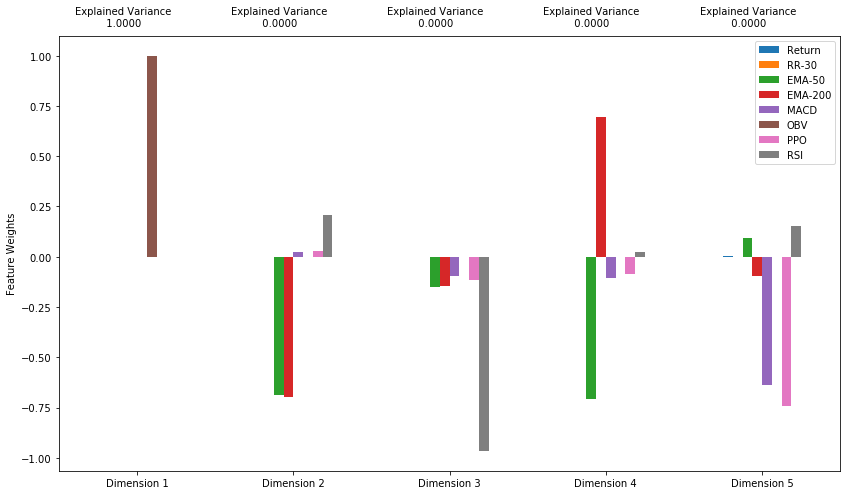

In [90]:
from sklearn.decomposition import PCA
import visuals as vs
pca = PCA(n_components=5)
pca.fit(X_train)
pca_results = vs.pca_results(X_train, pca)

### Train the model on the whole train set and report the accuracy on the test set

In [ ]:
performSVMGRClass(X_train, y_train, X_test, y_test, parameters, symbol, savemodel)

### Get Prediction from Best Model

In [27]:
def getPredictionFromBestModel(best_model):
    with open(best_model, 'rb') as fin:
        model = pickle.load(fin)
        
    return model.predict(X_test), model.score(X_test, y_test)

In [36]:
best_model = "LR_AAPL.pickle"
prediction_score_LR = getPredictionFromBestModel(best_model)[1]
prediction_LR = getPredictionFromBestModel(best_model)[0]
prediction_score_LR

0.5436241610738255

In [37]:
prediction_LR

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
print len(y_test)

149


In [31]:
y_test.head()

Date
2016-06-01    0
2016-06-02    1
2016-06-03    1
2016-06-06    1
2016-06-07    0
Name: UpDown, dtype: int64

In [ ]:
best_model = "KNN_AAPL.pickle"
prediction_score_KNN = getPredictionFromBestModel(best_model)[1]
prediction_score_KNN 

In [ ]:
best_model = "NB_AAPL.pickle"
prediction_score_NB = getPredictionFromBestModel(best_model)[1]
prediction_score_NB

## Backtesting

### Dataset Pre-processing

In [39]:
from abc import ABCMeta, abstractmethod
class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""
    __metaclass__ = ABCMeta
    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio 
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by 
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

In [40]:
backtest_data = getStockFromQuandl(symbol, start, end, 'Split Ratio')[['Adj. Open', 'Close']]
backtest_data = backtest_data.rename(columns={"Adj. Open": "Open"})

In [41]:
backtest_data.tail()

,Open,Close
Date,,
2016-12-23,114.162295,115.080808
2016-12-27,115.080808,115.811668
2016-12-28,116.068456,115.317843
2016-12-29,115.011672,115.288214
2016-12-30,115.209202,114.389454


### General Trading Assumption:

1. Assuming no transaction fees, no interests charged through short-selling.
2. If the signal is +1, then buy 100 shares of underlying stock. If the signal is -1, then sell 100 shares short. 

#### Market on Close Portfolio Strategy:
1. Use prediction for tomorrow to establish [positions], the order is executed after the market closed, therefore it is a Close-to-Close price difference.
2. First day of test period is nullified as there is no close price difference from the previous period. No position left at the beginning, so the trading execution starts on the second day.  
3. Every transaction is completed at the day's end. Bought shares would be sold at the closing price of the day, while the short-selling positons would be filled at the closing price. 


In [51]:
price_close = backtest_data['Close'][start_test:end]

predicted = pd.DataFrame(index=price_close.index)
predicted['signal'] = prediction_LR

# Make the signal of 'Down' day a "-1" as the protfolio would sell it 
predicted.signal[predicted.signal == 0] = -1
predicted['positions'] = predicted['signal'].diff()

In [46]:
price_close.head()

Date
2016-06-01    96.223736
2016-06-02    95.500543
2016-06-03    95.696001
2016-06-06    96.389875
2016-06-07    96.780790
Name: Close, dtype: float64

In [47]:
predicted.head()

,signal,positions
Date,,
2016-06-01,1,NaN
2016-06-02,1,0.0
2016-06-03,1,0.0
2016-06-06,1,0.0
2016-06-07,1,0.0


In [48]:
class MarketOnClosePortfolio(Portfolio):
    """Inherits Portfolio to create a system that purchases 100 units of 
    a particular symbol upon a long/short signal, assuming the market 
    open price of a bar.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    actual - A DataFrame of bars for a symbol set.
    predicted - A pandas DataFrame of signals (1, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, actual, predicted, initial_capital=100000.0, shares=100):
        self.symbol = symbol        
        self.actual = actual
        self.predicted = predicted
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """Generate the positions DataFrame, based on the signals
        provided by the 'signals' DataFrame."""
        positions = pd.DataFrame(index=self.predicted.index).fillna(0.0)
        positions[self.symbol] = 100*self.predicted['signal']
        return positions
                    
    def backtest_portfolio(self):
        """Constructs a portfolio from the positions DataFrame by 
        assuming the ability to trade at the precise market open price
        of each bar (an unrealistic assumption!). 

        Calculates the total of cash and the holdings (market price of
        each position per bar), in order to generate an equity curve
        ('total') and a set of bar-based returns ('returns').

        Returns the portfolio object to be used elsewhere."""

        # Construct the portfolio DataFrame to use the same index as 'positions' and with a set of 'trading orders' in the
        # 'pos_diff' object, assuming market open prices.
        
        portfolio = pd.DataFrame(index=self.positions.index)
            
        portfolio['price_diff'] = self.actual-self.actual.shift()
        portfolio['price_diff'][0:1] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']
        
        # Finalise the total and bar-based returns based on the 'cash' and 'holdings' figures for the portfolio
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

In [52]:
portfolio_close = MarketOnClosePortfolio(symbol, price_close, predicted)
returns_close = portfolio_close.backtest_portfolio()

In [54]:
returns_close.head()

,price_diff,profit,total,returns
Date,,,,
2016-06-01,0.000000,0.000000,100000.000000,NaN
2016-06-02,-0.723193,-72.319282,99927.680718,-0.000723
2016-06-03,0.195458,19.545752,99947.226470,0.000196
2016-06-06,0.693874,69.387419,100016.613889,0.000694
2016-06-07,0.390915,39.091504,100055.705393,0.000391


In [55]:
returns_close['total'][-1]-returns_close['total'][0]

1816.5717877786956

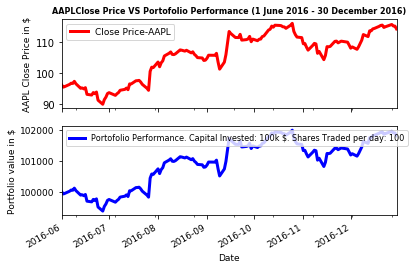

In [58]:
from matplotlib.dates import DAILY

f, ax = plt.subplots(2, sharex=True)
f.patch.set_facecolor('white')
ylabel = symbol + ' Close Price in $'
price_close.plot(ax=ax[0], color='r', lw=3.)    
ax[0].set_ylabel(ylabel, fontsize=9)
ax[0].set_xlabel('', fontsize=9)
ax[0].legend(('Close Price-' + symbol,), loc='upper left', prop={"size":9})
ax[0].set_title(symbol +'Close Price VS Portofolio Performance (1 June 2016 - 30 December 2016)', fontsize=8, fontweight="bold")

returns_close['total'].plot(ax=ax[1], color='b', lw=3.)  
ax[1].set_ylabel('Portfolio value in $', fontsize=9)
ax[1].set_xlabel('Date', fontsize=9)
ax[1].legend(('Portofolio Performance. Capital Invested: 100k $. Shares Traded per day: 100',), loc='upper left', prop={"size":8})            
plt.tick_params(axis='both', which='major', labelsize=9)
loc = ax[1].xaxis.get_major_locator()
loc.maxticks[DAILY] = 24

figManager = plt.get_current_fig_manager()
figManager.full_screen_toggle() 

plt.show()

#### Market On Open Portfolio Strategy
1. Use prediction for tomorrow to establish [positions], the order is executed at the market open, therefore it is a Open-to-Open price difference.
2. First day of test period is nullified as there is no open price difference from the previous period. No position left at the beginning, so the trading execution starts on the second day.  
3. Every transaction is completed at the day's beginning. Bought shares would be sold at the opening price of the day, while the short-selling positons would be filled at the opening price. 

In [59]:
price_open = backtest_data['Open'][start_test:end]

predicted = pd.DataFrame(index=price_open.index)
predicted['signal'] = prediction_LR

# Make the signal of 'Down' day a "-1" as the protfolio would sell it 
predicted.signal[predicted.signal == 0] = -1
predicted['positions'] = predicted['signal'].diff()

In [71]:
price_open.head()

Date
2016-06-01    96.771017
2016-06-02    95.383269
2016-06-03    95.568953
2016-06-06    95.764411
2016-06-07    96.995793
Name: Open, dtype: float64

In [72]:
predicted.head()

,signal,positions
Date,,
2016-06-01,1,NaN
2016-06-02,1,0.0
2016-06-03,1,0.0
2016-06-06,1,0.0
2016-06-07,1,0.0


In [62]:
from abc import ABCMeta, abstractmethod
class Portfolio_Open(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""
    __metaclass__ = ABCMeta
    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio 
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio_open(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by 
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

In [73]:
class MarketOnOpenPortfolio(Portfolio_Open):
    """Inherits Portfolio to create a system that purchases 100 units of 
    a particular symbol upon a long/short signal, assuming the market 
    open price of a bar.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    actual - A DataFrame of bars for a symbol set.
    predicted - A pandas DataFrame of signals (1, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, actual, predicted, initial_capital=100000.0, shares=100):
        self.symbol = symbol        
        self.actual = actual
        self.predicted = predicted
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """Generate the positions DataFrame, based on the signals
        provided by the 'signals' DataFrame."""
        positions = pd.DataFrame(index=self.predicted.index).fillna(0.0)
        positions[self.symbol] = 100*self.predicted['signal']
        return positions
    
    def backtest_portfolio_open(self):
        #portfolio = self.positions*self.actual['Open']
        #pos_diff = self.positions.diff()

        # Create the 'holdings' and 'cash' series by running through
        # the trades and adding/subtracting the relevant quantity from
        # each column
        #portfolio['holdings'] = (self.positions*self.bars['Open']).sum(axis=1)
        #portfolio['cash'] = self.initial_capital - (pos_diff*self.bars['Open']).sum(axis=1).cumsum()

        # Finalise the total and bar-based returns based on the 'cash'
        # and 'holdings' figures for the portfolio
        #portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        #portfolio['returns'] = portfolio['total'].pct_change()
        #return portfolio
    
        portfolio = pd.DataFrame(index=self.positions.index)
            
        portfolio['price_diff'] = self.actual-self.actual.shift()
        portfolio['price_diff'][0:1] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']
        
        # Finalise the total and bar-based returns based on the 'cash' and 'holdings' figures for the portfolio
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

In [74]:
portfolio_open = MarketOnOpenPortfolio(symbol, price_open, predicted)
returns_open = portfolio_open.backtest_portfolio_open()

In [75]:
returns_open.head()

,price_diff,profit,total,returns
Date,,,,
2016-06-01,0.000000,0.000000,100000.000000,NaN
2016-06-02,-1.387748,-138.774837,99861.225163,-0.001388
2016-06-03,0.185685,18.568464,99879.793627,0.000186
2016-06-06,0.195458,19.545752,99899.339378,0.000196
2016-06-07,1.231382,123.138236,100022.477615,0.001233


In [76]:
returns_open['total'][-1]-returns_open['total'][0]

1843.8185115896049

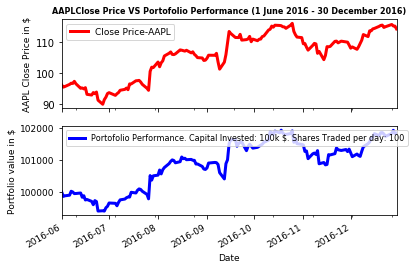

In [77]:
f, ax = plt.subplots(2, sharex=True)
f.patch.set_facecolor('white')
ylabel = symbol + ' Close Price in $'
price_close.plot(ax=ax[0], color='r', lw=3.)    
ax[0].set_ylabel(ylabel, fontsize=9)
ax[0].set_xlabel('', fontsize=9)
ax[0].legend(('Close Price-' + symbol,), loc='upper left', prop={"size":9})
ax[0].set_title(symbol +'Close Price VS Portofolio Performance (1 June 2016 - 30 December 2016)', fontsize=8, fontweight="bold")

returns_open['total'].plot(ax=ax[1], color='b', lw=3.)  
ax[1].set_ylabel('Portfolio value in $', fontsize=9)
ax[1].set_xlabel('Date', fontsize=9)
ax[1].legend(('Portofolio Performance. Capital Invested: 100k $. Shares Traded per day: 100',), loc='upper left', prop={"size":8})            
plt.tick_params(axis='both', which='major', labelsize=9)
loc = ax[1].xaxis.get_major_locator()
loc.maxticks[DAILY] = 24

figManager = plt.get_current_fig_manager()
figManager.full_screen_toggle() 

plt.show()

#### Market Intra-day Portfolio Strategy:
1. Use prediction for tomorrow to establish [positions], the order is executed at the market open and after the market closed, therefore it is a Close-to-Open price difference.
2. Every transaction is completed at the day's end. Bought shares would be sold at the opening price of the day, while the short-selliing positons would be filled at the closing price.

In [78]:
intra = backtest_data[start_test:end]

predicted = pd.DataFrame(index=intra.index)
predicted['signal'] = prediction_LR

# Make the signal of 'Down' day a "-1" as the protfolio would sell it 
predicted.signal[predicted.signal == 0] = -1
predicted['positions'] = predicted['signal'].diff()

In [79]:
intra.head()

,Open,Close
Date,,
2016-06-01,96.771017,96.223736
2016-06-02,95.383269,95.500543
2016-06-03,95.568953,95.696001
2016-06-06,95.764411,96.389875
2016-06-07,96.995793,96.780790


In [85]:
class MarketIntradayPortfolio(Portfolio):
    """Buys or sells 100 shares of an asset at the opening price of
    every bar, depending upon the direction of the forecast, closing 
    out the trade at the close of the bar.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, intra, predicted, initial_capital=100000.0, shares=100):
        self.symbol = symbol        
        self.intra = intra
        self.predicted = predicted
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """Generate the positions DataFrame, based on the signals
        provided by the 'signals' DataFrame."""
        positions = pd.DataFrame(index=self.predicted.index).fillna(0.0)
        positions[self.symbol] = self.shares*self.predicted['signal']
        return positions                               
        
    def backtest_portfolio(self):
        """Backtest the portfolio and return a DataFrame containing
        the equity curve and the percentage returns."""
       
        portfolio = pd.DataFrame(index=self.positions.index)                  
        portfolio['price_diff'] = self.intra['Close']-self.intra['Open']
        portfolio['price_diff'][0:1] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']
     
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio
    


In [86]:
portfolio = MarketIntradayPortfolio(symbol, intra, predicted)
returns_intra = portfolio.backtest_portfolio()

In [87]:
returns_intra['total'][-1]-returns_intra['total'][0]

2012.114980917002

In [88]:
returns_intra.head()

,price_diff,profit,total,returns
Date,,,,
2016-06-01,0.000000,0.000000,100000.000000,NaN
2016-06-02,0.117275,11.727451,100011.727451,0.000117
2016-06-03,0.127047,12.704739,100024.432190,0.000127
2016-06-06,0.625464,62.546406,100086.978595,0.000625
2016-06-07,-0.215003,-21.500327,100065.478268,-0.000215


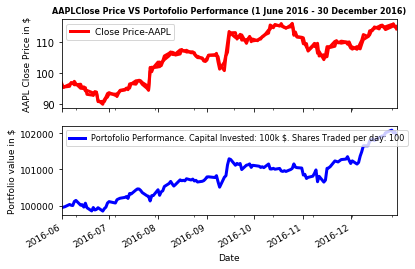

In [84]:
f, ax = plt.subplots(2, sharex=True)
f.patch.set_facecolor('white')
ylabel = symbol + ' Close Price in $'
intra.plot(ax=ax[0], color='r', lw=3.)    
ax[0].set_ylabel(ylabel, fontsize=9)
ax[0].set_xlabel('', fontsize=9)
ax[0].legend(('Close Price-' + symbol,), loc='upper left', prop={"size":9})
ax[0].set_title(symbol +'Close Price VS Portofolio Performance (1 June 2016 - 30 December 2016)', fontsize=8, fontweight="bold")

returns_intra['total'].plot(ax=ax[1], color='b', lw=3.)  
ax[1].set_ylabel('Portfolio value in $', fontsize=9)
ax[1].set_xlabel('Date', fontsize=9)
ax[1].legend(('Portofolio Performance. Capital Invested: 100k $. Shares Traded per day: 100',), loc='upper left', prop={"size":8})            
plt.tick_params(axis='both', which='major', labelsize=9)
loc = ax[1].xaxis.get_major_locator()
loc.maxticks[DAILY] = 24

figManager = plt.get_current_fig_manager()
figManager.full_screen_toggle() 

plt.show()